In [ ]:
import sys 
import numpy as np
import math
import numba
from numba import cuda, int64, jit
from numba.cuda import random as rnd
from timeit import default_timer as timer
from scipy.stats import binom, poisson
import pickle as pkl
import os
os.system("ml CUDA")

0

In [ ]:
@cuda.jit
def sumF(fitnessarr,F):
    F[0]=0
    for i in range(fitnessarr.shape[0]):
        F[0]+=fitnessarr[i]

The general algorithm works as follows. In each generation we will sample the parents, copy their genome and add muations.

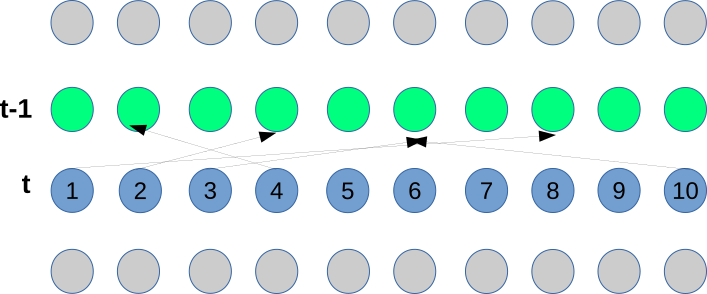


In order to not overwrite the parent genomes we need to keep them for one generation.

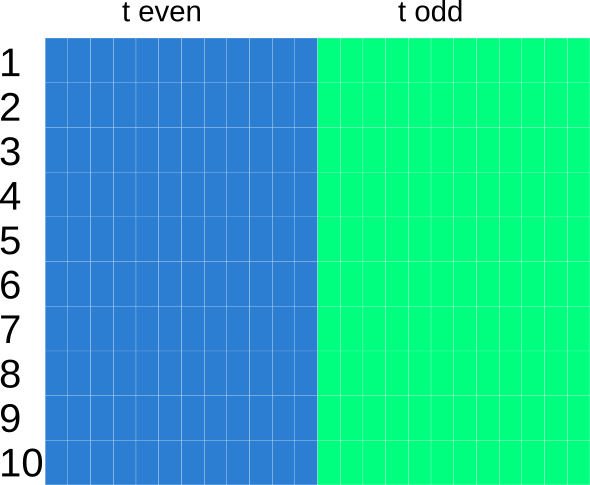

In [ ]:
@cuda.jit
def evolve(rng_states,gen,numberGenerations,genotypes,reference,binomcdf,fitnessarr,F,s):
    cellThreadID = cuda.grid(1)
    genoblocks = genotypes.shape[1]/2
    L=64*genoblocks
    N=genotypes.shape[0]
    numberLocalCells = 1
    for numbIt in range(numberGenerations):
        for localI in range(numberLocalCells):
            cellID = (cellThreadID*numberLocalCells) + localI
            if cellID < N:
                if (gen+numbIt) % 2 == 1:
                    targetoffset = 0
                    sourceoffset = int(genotypes.shape[1]/2)
                else:
                    targetoffset = int(genotypes.shape[1]/2)
                    sourceoffset = 0
                #choose a random parent (according to fitnesses)
                r=F[0]*rnd.xoroshiro128p_uniform_float32(rng_states, cellThreadID)
                for i in range(N):
                    if r<fitnessarr[i]:
                        parent=i
                        break
                    else:
                        r-=fitnessarr[i]
                for i in range(genoblocks):
                    genotypes[cellID,i+targetoffset]=genotypes[parent,i+sourceoffset]
                #add mutations
                r=rnd.xoroshiro128p_uniform_float32(rng_states, cellThreadID)
                for k in range(100):
                    if r < binomcdf[k]:
                        break
                numberMutations=k
                for i in range(numberMutations):
                    pos = 2*int(math.floor(L/2*rnd.xoroshiro128p_uniform_float32(rng_states, cellThreadID)))
                    posInt = pos//64
                    posInInt = pos%64
                    r=rnd.xoroshiro128p_uniform_float32(rng_states, cellThreadID)
                    if r < 1/4:
                        #transverion (first bit with probability 1/2)
                        if r < 1/8:
                            genotypes[cellID,posInt+targetoffset]=genotypes[cellID,posInt+targetoffset] ^ 2**posInInt
                        #second bit has to be flipped
                        genotypes[cellID,posInt+targetoffset]=genotypes[cellID,posInt+targetoffset] ^ 2**(posInInt+1)
                    else:
                        #transition (00<->10 or 01<->11)
                        genotypes[cellID,posInt+targetoffset]=genotypes[cellID,posInt+targetoffset] ^ 2**posInInt
                snpCount=0
                for posInt in range(genoblocks):
                    intAnd=(genotypes[cellID,posInt+targetoffset] ^ reference[posInt])
                    for posInInt in range(0,64,2):
                        if intAnd & 2**posInInt > 0 or intAnd & 2**(posInInt+1) > 0:
                            snpCount+=1
                fitnessarr[cellID]=s**snpCount
        cuda.syncthreads()

In [ ]:
from scipy.optimize import fsolve
def mufunct(mu,N,S,fractionvariable):
    return np.prod([1/(1+2*mu*N/(k-1)) for k in range(2,S+1)])-fractionvariable

In [ ]:
L=10000
n=64*L
threadsperblock = 20
blocks = 20
N=threadsperblock*blocks
S=50
s=0.999
fractionvariable=0.9
p2=fsolve(mufunct,0.000001,args=(N,S,fractionvariable))[0]
print("p2: "+str(p2))
binomcdf = np.zeros((100),dtype=np.float32)
for k in range(100):
    binomcdf[k]=binom.cdf(k, n, p2)
SEED=1

NUMCYCLES=8*N
#subindx=range(0,S)
genotypes = np.array(np.reshape(np.array(list(np.random.randint(0,2**64, L*2,dtype=np.uint64))*2*N),(N,L*4)), dtype=np.uint64)
devgenotypes = cuda.to_device(genotypes)
reference = np.copy(genotypes[0,:])
devreference = cuda.to_device(reference)
devbinomcdf = cuda.to_device(binomcdf)
fitnessarr = np.ones(N)
F=np.sum(fitnessarr)
devfitnessarr=cuda.to_device(fitnessarr)
rng_states = rnd.create_xoroshiro128p_states(threadsperblock * blocks, seed=SEED)
F=cuda.device_array((1))
sumF[1,1](devfitnessarr,F)

p2: 2.9527733276073623e-05


In [ ]:
start = timer()
evolve[blocks, threadsperblock](rng_states,0,1,devgenotypes,devreference,devbinomcdf,devfitnessarr,F,s)
sumF[1,1](devfitnessarr,F)
evolve_time=timer()-start
print("first iteration: "+str(evolve_time))

first iteration: 1.1561362750362605


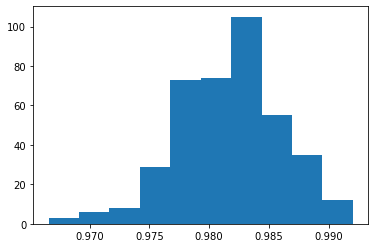

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
fitnessarr=devfitnessarr.copy_to_host()
plt.hist(fitnessarr)
plt.show()

In [ ]:
start = timer()
for i in range(1,1001):
    #start = timer()
    evolve[blocks, threadsperblock](rng_states,i,1,devgenotypes,devreference,devbinomcdf,devfitnessarr,F,s)
    #fitnessarr=devfitnessarr.copy_to_host()
    #print(F)
    sumF[1,1](devfitnessarr,F)
    #print(F)
    #print(fitnessarr)
    #F=np.sum(fitnessarr)
#print(F)
cuda.synchronize()
evolve_time=timer()-start
print("1000 more iterations: "+str(evolve_time))

1000 more iterations: 378.1977686799364


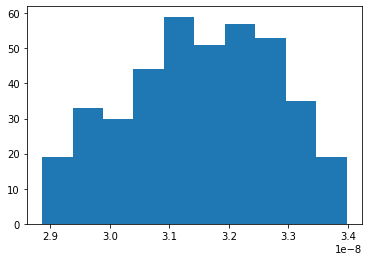

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
fitnessarr=devfitnessarr.copy_to_host()
plt.hist(fitnessarr)
plt.show()

In [ ]:
start = timer()
for i in range(1001,NUMCYCLES):
    evolve[blocks, threadsperblock](rng_states,i,1,devgenotypes,devreference,devbinomcdf,devfitnessarr,F,s)
    #fitnessarr=devfitnessarr.copy_to_host()
    #F=np.sum(fitnessarr)
    #cuda.synchronize()
    sumF[1,1](devfitnessarr,F)
Fl=F.copy_to_host()
print(Fl)
#fitnessarr=devfitnessarr.copy_to_host()
#print(fitnessarr)
cuda.synchronize()
evolve_time=timer()-start
print("remaining "+str(NUMCYCLES-1000)+" cylcles: "+str(evolve_time)+"\n")

[6.5633725e-21]
remaining 2200 cylcles: 820.6376358000562



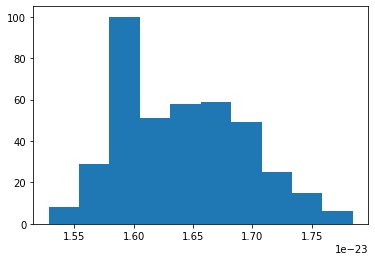

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
fitnessarr=devfitnessarr.copy_to_host()
plt.hist(fitnessarr)
plt.show()